# Importing Libraries

In [1]:
import pandas as pd
from sqlalchemy import create_engine

# Creating the Connection

In [2]:
from sqlalchemy import create_engine
from config import DB_USER, DB_PASSWORD, DB_HOST, DB_PORT, DB_NAME

engine = create_engine(
    f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)


# Pulling Data from SQL

In [3]:
query = """
SELECT
    feature_date,
    product_id,
    location_id,
    units_sold,
    sales_lag_1,
    sales_lag_7,
    rolling_avg_7,
    rolling_avg_30
FROM product_sales_features
WHERE product_id = 101
  AND location_id = 1
ORDER BY feature_date;
"""

df = pd.read_sql(query, engine)


In [4]:
# checking the data
print(df.head())

  feature_date  product_id  location_id  units_sold  sales_lag_1  sales_lag_7  \
0   2023-01-19         101            1           7          NaN          NaN   
1   2023-01-22         101            1           4          7.0          NaN   
2   2023-01-25         101            1           7          4.0          NaN   
3   2023-02-03         101            1           4          7.0          NaN   
4   2023-02-07         101            1           5          4.0          NaN   

   rolling_avg_7  rolling_avg_30  
0            7.0             7.0  
1            5.5             5.5  
2            6.0             6.0  
3            5.5             5.5  
4            5.4             5.4  


# Handling Missing Values
- LAG features create NULLs
- ML models need NULLs removed

In [5]:
df = df.dropna()


## Defining Features (X) and target (y)
- Target is what we predict (y)
- Features (X) are what we use to predict the target

### Target

In [6]:
y = df["units_sold"]

### Features

In [7]:
X = df[
    [
        "sales_lag_1",
        "sales_lag_7",
        "rolling_avg_7",
        "rolling_avg_30"
    ]
]


# Training a baseline forecasting model
- Normally start with Linear Regression because it’s interpretable.

In [8]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)


LinearRegression()

# Make Predictions

In [9]:
df["predicted_units"] = model.predict(X)


In [10]:
# Inspect
print(df[["feature_date", "units_sold", "predicted_units"]].tail())


   feature_date  units_sold  predicted_units
49   2023-12-10           5         6.250430
50   2023-12-13           6         6.391417
51   2023-12-15           3         6.473973
52   2023-12-22           5         6.562664
53   2023-12-23           9         6.706068


# Visualize actual vs predicted
- Very critical

In [11]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

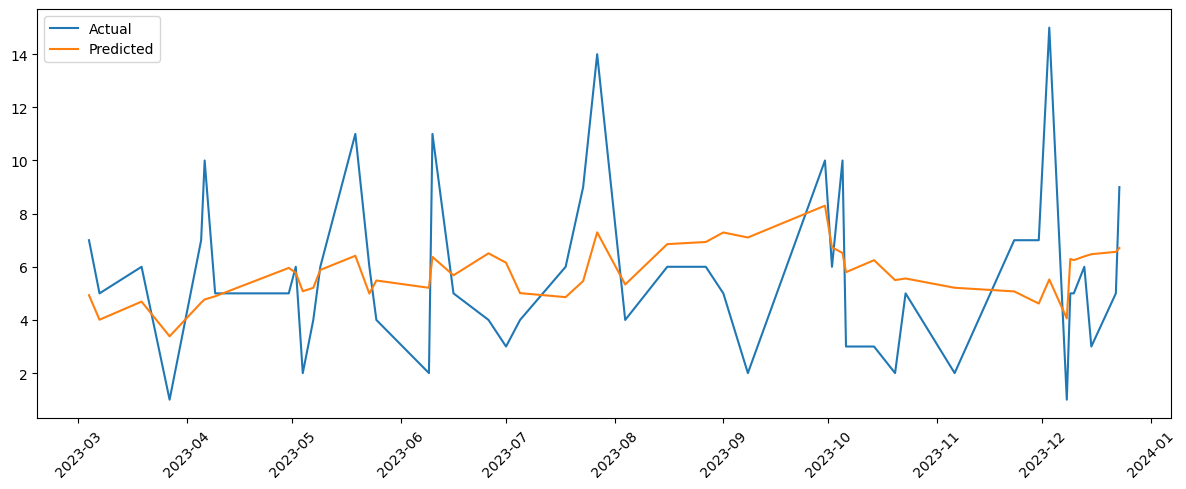

In [12]:

plt.figure(figsize=(12, 5))  # wider chart

plt.plot(df["feature_date"], df["units_sold"], label="Actual")
plt.plot(df["feature_date"], df["predicted_units"], label="Predicted")

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# Forecast Evaluation
- Checking how right or wrong the forecast is
- MAE (Mean Absolute Error) - On average, how many units are we off?
- RMSE (Root Mean Squared Error) - Penalises big mistakes more heavily

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [14]:
mae = mean_absolute_error(df["units_sold"], df["predicted_units"])
rmse = np.sqrt(mean_squared_error(df["units_sold"], df["predicted_units"]))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 2.35
RMSE: 2.96


In [15]:
# compare with typical demand
df["units_sold"].mean()

np.float64(5.74468085106383)

# Finishing the Model by Creating the Forecast Table in PostgreSQL
- The next step involves creating the table in PostgreSQL and then later preparing the data

# Preparing the Data in Python

In [16]:
forecast_df = df[
    [
        "feature_date",
        "product_id",
        "location_id",
        "predicted_units"
    ]
].copy()


In [21]:
# Renaming columns to match the SQL table
forecast_df = forecast_df.rename(
    columns={"feature_date": "forecast_date"}
)


In [28]:
# Adding metadata
forecast_df["model_name"] = "linear_regression"
forecast_df["model_version"] = "v1"



### Writing Predictions into PostgreSQL

In [29]:
from sqlalchemy import create_engine
from config import DB_USER, DB_PASSWORD, DB_HOST, DB_PORT, DB_NAME

engine = create_engine(
    f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)


In [30]:
forecast_df.to_sql(
    "demand_forecasts",
    engine,
    if_exists="append",
    index=False,
    method="multi"
)


47

- So far, the forecasting explains the today's performance given the past performance. 
- However, true forecasting involves evaluating what will happen in the future.

# True Forecasting

### Defining the forecasting horizon
- 7 Days Forecasting (realistic and manageable)
- Wider uncertainty after 10–14 days with a linear model

### Split history vs future
Rule: Training data must only contain dates BEFORE the forecast start date

In [31]:
# last available date
last_date = df["feature_date"].max()
print(last_date)


2023-12-23


### Creating Future Dates

In [32]:
import pandas as pd

future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=7,
    freq="D"
)


- The main concern is that units_sold is unknown
- However, lagged features are derived from historical ffeatures
- this methid is recursive forecasting

### Preparing the last known feature state

In [33]:
last_row = df.sort_values("feature_date").iloc[-1]


## Generating Future Forecasts

In [34]:
future_predictions = []

current_lag_1 = last_row["units_sold"]
current_lag_7 = last_row["sales_lag_7"]
current_avg_7 = last_row["rolling_avg_7"]
current_avg_30 = last_row["rolling_avg_30"]

for date in future_dates:
    X_future = pd.DataFrame([{
        "sales_lag_1": current_lag_1,
        "sales_lag_7": current_lag_7,
        "rolling_avg_7": current_avg_7,
        "rolling_avg_30": current_avg_30
    }])

    pred = model.predict(X_future)[0]

    future_predictions.append({
        "forecast_date": date,
        "predicted_units": pred
    })

    # update lags for next day
    current_lag_7 = current_lag_1
    current_lag_1 = pred
    current_avg_7 = (current_avg_7 * 6 + pred) / 7
    current_avg_30 = (current_avg_30 * 29 + pred) / 30


## Creating Future Forecast Dataframe

In [35]:
future_forecast_df = pd.DataFrame(future_predictions)
print(future_forecast_df)


  forecast_date  predicted_units
0    2023-12-24         6.160158
1    2023-12-25         5.671203
2    2023-12-26         5.322564
3    2023-12-27         5.309170
4    2023-12-28         5.268878
5    2023-12-29         5.283158
6    2023-12-30         5.285595


In [ ]:
# Model Improvement from Linear to Tree Based

Why the current model struggles (quick diagnosis). The linear model:
- Assumes straight-line relationships
- Averages spikes away
- Cannot model thresholds (e.g., promos suddenly doubling demand)
- The errors (MAE ~2.35 on mean ~5.7) confirm this.

Tree-based models fix this problem.

Random Forest Regressor is the first step (not XGBoost yet):
- Handles non-linearity
- Robust to noise
- Minimal tuning
- Easy to interpret

### Keeping the same features

In [36]:
X = df[
    [
        "sales_lag_1",
        "sales_lag_7",
        "rolling_avg_7",
        "rolling_avg_30"
    ]
]

y = df["units_sold"]


### Training a Random Forest Model
The following elements are used (intentionally)
- n_estimators=300 → stable predictions
- max_depth=8 → prevents overfitting
- min_samples_leaf=5 → smooths noise

In [37]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=5,
    random_state=42
)

rf_model.fit(X, y)


RandomForestRegressor(max_depth=8, min_samples_leaf=5, n_estimators=300,
                      random_state=42)

#### Predicting the improved model

In [38]:
df["rf_predicted_units"] = rf_model.predict(X)


### Evaluating the Improved Model

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

rf_mae = mean_absolute_error(df["units_sold"], df["rf_predicted_units"])
rf_rmse = np.sqrt(mean_squared_error(df["units_sold"], df["rf_predicted_units"]))

print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"Random Forest RMSE: {rf_rmse:.2f}")


Random Forest MAE: 2.04
Random Forest RMSE: 2.61


*What changed*

*Before (Linear Regression):*
- MAE = 2.35
- RMSE = 2.96

*After (Random Forest):*
- MAE = 2.04
- RMSE = 2.61

*Improvement:*
- MAE ↓ about 13%
- RMSE ↓ about 12%

*This is a meaningful improvement*

### Visual Comparison

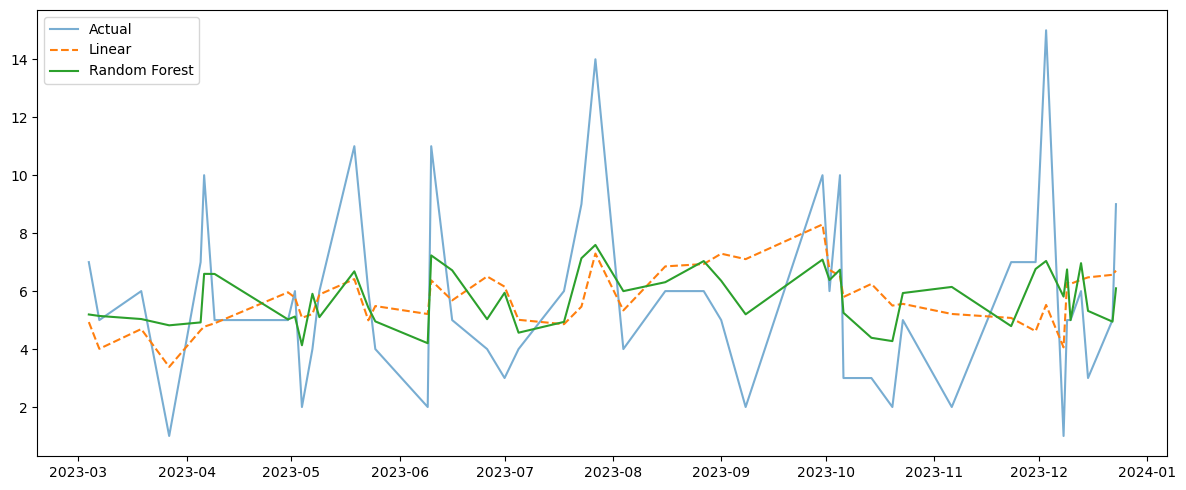

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12,5))

plt.plot(df["feature_date"], df["units_sold"], label="Actual", alpha=0.6)
plt.plot(df["feature_date"], df["predicted_units"], label="Linear", linestyle="--")
plt.plot(df["feature_date"], df["rf_predicted_units"], label="Random Forest")

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.legend()
plt.tight_layout()
plt.show()


### Feature Importance

In [41]:
import pandas as pd

importance = pd.DataFrame({
    "feature": X.columns,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)

print(importance)


          feature  importance
1     sales_lag_7    0.395894
2   rolling_avg_7    0.263973
3  rolling_avg_30    0.174680
0     sales_lag_1    0.165453


## Replace Linear Regression with Random Forest for 30-Day Forecasting

### Confirm the Random Forest model is trained

In [42]:
rf_model.fit(X, y)


RandomForestRegressor(max_depth=8, min_samples_leaf=5, n_estimators=300,
                      random_state=42)

### Define the 30-day forecast horizon

In [43]:
import pandas as pd

last_date = df["feature_date"].max()

future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=30,
    freq="D"
)


### Capture the last known real state

In [44]:
last_row = df.sort_values("feature_date").iloc[-1]

current_lag_1 = last_row["units_sold"]
current_lag_7 = last_row["sales_lag_7"]
current_avg_7 = last_row["rolling_avg_7"]
current_avg_30 = last_row["rolling_avg_30"]


### Recursive forecasting using Random 
This is the only part that changes.

In [46]:
future_predictions = []

for date in future_dates:
    X_future = pd.DataFrame([{
        "sales_lag_1": current_lag_1,
        "sales_lag_7": current_lag_7,
        "rolling_avg_7": current_avg_7,
        "rolling_avg_30": current_avg_30
    }])

# Random Forest replaces linear model
    pred = rf_model.predict(X_future)[0]

    future_predictions.append({
        "forecast_date": date,
        "predicted_units": float(pred)
    })

# update state for next step
    current_lag_7 = current_lag_1
    current_lag_1 = pred
    current_avg_7 = (current_avg_7 * 6 + pred) / 7
    current_avg_30 = (current_avg_30 * 29 + pred) / 30


### Create the future forecast DataFrame

In [47]:
future_forecast_df = pd.DataFrame(future_predictions)
print(future_forecast_df.head())
print(future_forecast_df.tail())


  forecast_date  predicted_units
0    2023-12-24         4.573324
1    2023-12-25         4.580256
2    2023-12-26         4.580256
3    2023-12-27         4.611549
4    2023-12-28         4.611549
   forecast_date  predicted_units
25    2024-01-18         4.619215
26    2024-01-19         4.619215
27    2024-01-20         4.619215
28    2024-01-21         4.619215
29    2024-01-22         4.619215


### Visualise History

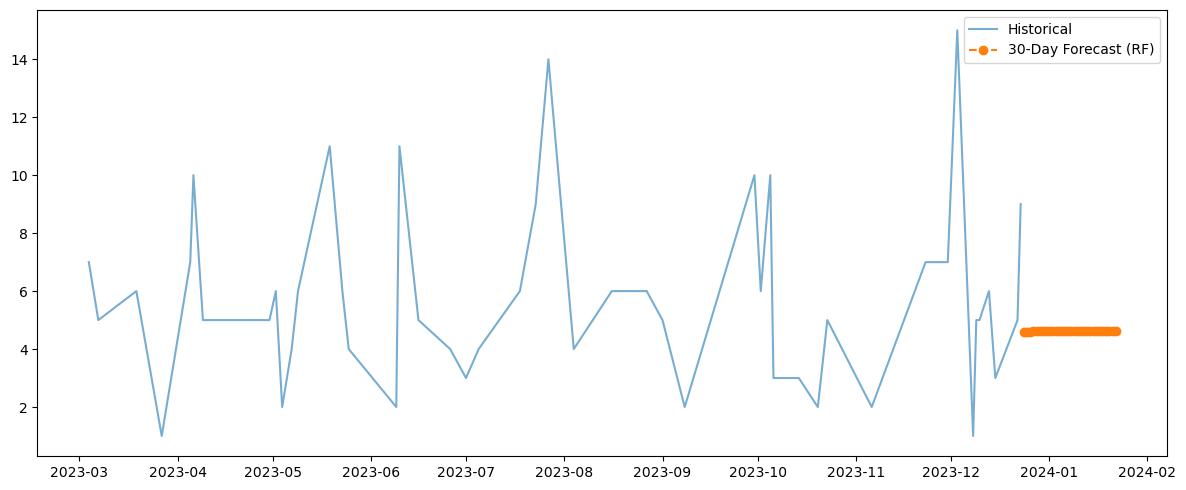

In [48]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12,5))

plt.plot(
    df["feature_date"],
    df["units_sold"],
    label="Historical",
    alpha=0.6
)

plt.plot(
    future_forecast_df["forecast_date"],
    future_forecast_df["predicted_units"],
    label="30-Day Forecast (RF)",
    linestyle="--",
    marker="o"
)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.legend()
plt.tight_layout()
plt.show()


## Calendar and Promo Feature Engineering

### Pulling the new features into Python

In [49]:
query = """
SELECT
    feature_date,
    product_id,
    location_id,
    units_sold,
    sales_lag_1,
    sales_lag_7,
    rolling_avg_7,
    rolling_avg_30,
    dow,
    is_weekend,
    month
FROM product_sales_features_v2
WHERE product_id = 101
  AND location_id = 1
ORDER BY feature_date;
"""

df2 = pd.read_sql(query, engine)
df2["feature_date"] = pd.to_datetime(df2["feature_date"])
df2 = df2.dropna()


### Train Random Forest with Calendar Features

In [50]:
# Defining Features and Targets
X2 = df2[
    [
        "sales_lag_1",
        "sales_lag_7",
        "rolling_avg_7",
        "rolling_avg_30",
        "dow",
        "is_weekend",
        "month"
    ]
]

y2 = df2["units_sold"]


In [51]:
# Training the Model
from sklearn.ensemble import RandomForestRegressor

rf_model_v2 = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42
)

rf_model_v2.fit(X2, y2)


RandomForestRegressor(max_depth=10, min_samples_leaf=5, n_estimators=400,
                      random_state=42)

### Evaluating the Improvement

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

pred2 = rf_model_v2.predict(X2)

mae2 = mean_absolute_error(y2, pred2)
rmse2 = np.sqrt(mean_squared_error(y2, pred2))

print(f"RF + Calendar MAE: {mae2:.2f}")
print(f"RF + Calendar RMSE: {rmse2:.2f}")


RF + Calendar MAE: 1.95
RF + Calendar RMSE: 2.50


### Feature Importance

In [53]:
import pandas as pd

importance = pd.DataFrame({
    "feature": X2.columns,
    "importance": rf_model_v2.feature_importances_
}).sort_values("importance", ascending=False)

print(importance)


          feature  importance
1     sales_lag_7    0.284227
2   rolling_avg_7    0.177748
4             dow    0.162909
3  rolling_avg_30    0.127735
0     sales_lag_1    0.123281
5      is_weekend    0.071852
6           month    0.052248


## Rerun the 30-Day Future Forecast (RF and Calendar)

### Defining the forecast horizon

In [54]:
import pandas as pd

last_date = df2["feature_date"].max()

future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=30,
    freq="D"
)


### Finding the last known

In [55]:
last_row = df2.sort_values("feature_date").iloc[-1]

current_lag_1 = last_row["units_sold"]
current_lag_7 = last_row["sales_lag_7"]
current_avg_7 = last_row["rolling_avg_7"]
current_avg_30 = last_row["rolling_avg_30"]


### Recursive 30-Day Forecasting

In [56]:
future_predictions = []

for date in future_dates:
    dow = date.weekday()          # Monday=0 … Sunday=6
    is_weekend = 1 if dow >= 5 else 0
    month = date.month

    X_future = pd.DataFrame([{
        "sales_lag_1": current_lag_1,
        "sales_lag_7": current_lag_7,
        "rolling_avg_7": current_avg_7,
        "rolling_avg_30": current_avg_30,
        "dow": dow,
        "is_weekend": is_weekend,
        "month": month
    }])

    pred = rf_model_v2.predict(X_future)[0]

    future_predictions.append({
        "forecast_date": date,
        "predicted_units": float(pred)
    })

    # Update state for next step
    current_lag_7 = current_lag_1
    current_lag_1 = pred
    current_avg_7 = (current_avg_7 * 6 + pred) / 7
    current_avg_30 = (current_avg_30 * 29 + pred) / 30


### Create the Forecast Dataframe

In [57]:
future_forecast_df_v2 = pd.DataFrame(future_predictions)

print(future_forecast_df_v2.head())
print(future_forecast_df_v2.tail())


  forecast_date  predicted_units
0    2023-12-24         6.597658
1    2023-12-25         6.659048
2    2023-12-26         5.894167
3    2023-12-27         5.677779
4    2023-12-28         5.294419
   forecast_date  predicted_units
25    2024-01-18         5.217202
26    2024-01-19         5.039240
27    2024-01-20         4.887949
28    2024-01-21         4.978521
29    2024-01-22         5.064533


### Visualise the History and Improved Forecast

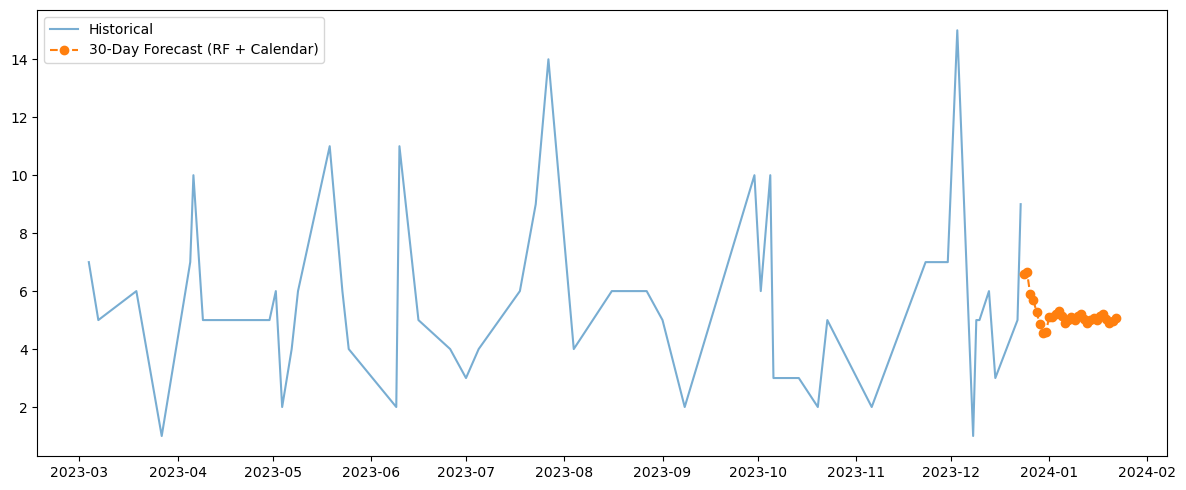

In [58]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12,5))

plt.plot(
    df2["feature_date"],
    df2["units_sold"],
    label="Historical",
    alpha=0.6
)

plt.plot(
    future_forecast_df_v2["forecast_date"],
    future_forecast_df_v2["predicted_units"],
    label="30-Day Forecast (RF + Calendar)",
    linestyle="--",
    marker="o"
)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.legend()
plt.tight_layout()
plt.show()


## Preparing the v2 forecast data in Python

In [59]:
forecast_v2 = future_forecast_df_v2.copy()

forecast_v2["product_id"] = 101
forecast_v2["location_id"] = 1
forecast_v2["model_name"] = "random_forest"
forecast_v2["model_version"] = "rf_calendar_v2"


In [60]:
# Reordering columns to match SQl
forecast_v2 = forecast_v2[
    [
        "forecast_date",
        "product_id",
        "location_id",
        "predicted_units",
        "model_name",
        "model_version"
    ]
]


In [61]:
print(forecast_v2.head())


  forecast_date  product_id  location_id  predicted_units     model_name  \
0    2023-12-24         101            1         6.597658  random_forest   
1    2023-12-25         101            1         6.659048  random_forest   
2    2023-12-26         101            1         5.894167  random_forest   
3    2023-12-27         101            1         5.677779  random_forest   
4    2023-12-28         101            1         5.294419  random_forest   

    model_version  
0  rf_calendar_v2  
1  rf_calendar_v2  
2  rf_calendar_v2  
3  rf_calendar_v2  
4  rf_calendar_v2  


### Writing Data into the SQl

In [62]:
engine.dispose()


In [63]:
from sqlalchemy import create_engine
from config import DB_USER, DB_PASSWORD, DB_HOST, DB_PORT, DB_NAME

engine = create_engine(
    f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

In [64]:
forecast_v2.to_sql(
    "demand_forecasts",
    engine,
    if_exists="append",
    index=False,
    method="multi"
)


IntegrityError: (psycopg2.errors.UniqueViolation) duplicate key value violates unique constraint "demand_forecasts_pkey"
DETAIL:  Key (forecast_date, product_id, location_id, model_name)=(2023-12-24, 101, 1, random_forest) already exists.

[SQL: INSERT INTO demand_forecasts (forecast_date, product_id, location_id, predicted_units, model_name, model_version) VALUES (%(forecast_date_m0)s, %(product_id_m0)s, %(location_id_m0)s, %(predicted_units_m0)s, %(model_name_m0)s, %(model_version_m0)s), (%(forecast_date_m1)s, %(product_id_m1)s, %(location_id_m1)s, %(predicted_units_m1)s, %(model_name_m1)s, %(model_version_m1)s), (%(forecast_date_m2)s, %(product_id_m2)s, %(location_id_m2)s, %(predicted_units_m2)s, %(model_name_m2)s, %(model_version_m2)s), (%(forecast_date_m3)s, %(product_id_m3)s, %(location_id_m3)s, %(predicted_units_m3)s, %(model_name_m3)s, %(model_version_m3)s), (%(forecast_date_m4)s, %(product_id_m4)s, %(location_id_m4)s, %(predicted_units_m4)s, %(model_name_m4)s, %(model_version_m4)s), (%(forecast_date_m5)s, %(product_id_m5)s, %(location_id_m5)s, %(predicted_units_m5)s, %(model_name_m5)s, %(model_version_m5)s), (%(forecast_date_m6)s, %(product_id_m6)s, %(location_id_m6)s, %(predicted_units_m6)s, %(model_name_m6)s, %(model_version_m6)s), (%(forecast_date_m7)s, %(product_id_m7)s, %(location_id_m7)s, %(predicted_units_m7)s, %(model_name_m7)s, %(model_version_m7)s), (%(forecast_date_m8)s, %(product_id_m8)s, %(location_id_m8)s, %(predicted_units_m8)s, %(model_name_m8)s, %(model_version_m8)s), (%(forecast_date_m9)s, %(product_id_m9)s, %(location_id_m9)s, %(predicted_units_m9)s, %(model_name_m9)s, %(model_version_m9)s), (%(forecast_date_m10)s, %(product_id_m10)s, %(location_id_m10)s, %(predicted_units_m10)s, %(model_name_m10)s, %(model_version_m10)s), (%(forecast_date_m11)s, %(product_id_m11)s, %(location_id_m11)s, %(predicted_units_m11)s, %(model_name_m11)s, %(model_version_m11)s), (%(forecast_date_m12)s, %(product_id_m12)s, %(location_id_m12)s, %(predicted_units_m12)s, %(model_name_m12)s, %(model_version_m12)s), (%(forecast_date_m13)s, %(product_id_m13)s, %(location_id_m13)s, %(predicted_units_m13)s, %(model_name_m13)s, %(model_version_m13)s), (%(forecast_date_m14)s, %(product_id_m14)s, %(location_id_m14)s, %(predicted_units_m14)s, %(model_name_m14)s, %(model_version_m14)s), (%(forecast_date_m15)s, %(product_id_m15)s, %(location_id_m15)s, %(predicted_units_m15)s, %(model_name_m15)s, %(model_version_m15)s), (%(forecast_date_m16)s, %(product_id_m16)s, %(location_id_m16)s, %(predicted_units_m16)s, %(model_name_m16)s, %(model_version_m16)s), (%(forecast_date_m17)s, %(product_id_m17)s, %(location_id_m17)s, %(predicted_units_m17)s, %(model_name_m17)s, %(model_version_m17)s), (%(forecast_date_m18)s, %(product_id_m18)s, %(location_id_m18)s, %(predicted_units_m18)s, %(model_name_m18)s, %(model_version_m18)s), (%(forecast_date_m19)s, %(product_id_m19)s, %(location_id_m19)s, %(predicted_units_m19)s, %(model_name_m19)s, %(model_version_m19)s), (%(forecast_date_m20)s, %(product_id_m20)s, %(location_id_m20)s, %(predicted_units_m20)s, %(model_name_m20)s, %(model_version_m20)s), (%(forecast_date_m21)s, %(product_id_m21)s, %(location_id_m21)s, %(predicted_units_m21)s, %(model_name_m21)s, %(model_version_m21)s), (%(forecast_date_m22)s, %(product_id_m22)s, %(location_id_m22)s, %(predicted_units_m22)s, %(model_name_m22)s, %(model_version_m22)s), (%(forecast_date_m23)s, %(product_id_m23)s, %(location_id_m23)s, %(predicted_units_m23)s, %(model_name_m23)s, %(model_version_m23)s), (%(forecast_date_m24)s, %(product_id_m24)s, %(location_id_m24)s, %(predicted_units_m24)s, %(model_name_m24)s, %(model_version_m24)s), (%(forecast_date_m25)s, %(product_id_m25)s, %(location_id_m25)s, %(predicted_units_m25)s, %(model_name_m25)s, %(model_version_m25)s), (%(forecast_date_m26)s, %(product_id_m26)s, %(location_id_m26)s, %(predicted_units_m26)s, %(model_name_m26)s, %(model_version_m26)s), (%(forecast_date_m27)s, %(product_id_m27)s, %(location_id_m27)s, %(predicted_units_m27)s, %(model_name_m27)s, %(model_version_m27)s), (%(forecast_date_m28)s, %(product_id_m28)s, %(location_id_m28)s, %(predicted_units_m28)s, %(model_name_m28)s, %(model_version_m28)s), (%(forecast_date_m29)s, %(product_id_m29)s, %(location_id_m29)s, %(predicted_units_m29)s, %(model_name_m29)s, %(model_version_m29)s)]
[parameters: {'forecast_date_m0': datetime.datetime(2023, 12, 24, 0, 0), 'product_id_m0': 101, 'location_id_m0': 1, 'predicted_units_m0': 6.597658372877123, 'model_name_m0': 'random_forest', 'model_version_m0': 'rf_calendar_v2', 'forecast_date_m1': datetime.datetime(2023, 12, 25, 0, 0), 'product_id_m1': 101, 'location_id_m1': 1, 'predicted_units_m1': 6.6590483948993064, 'model_name_m1': 'random_forest', 'model_version_m1': 'rf_calendar_v2', 'forecast_date_m2': datetime.datetime(2023, 12, 26, 0, 0), 'product_id_m2': 101, 'location_id_m2': 1, 'predicted_units_m2': 5.8941674331323135, 'model_name_m2': 'random_forest', 'model_version_m2': 'rf_calendar_v2', 'forecast_date_m3': datetime.datetime(2023, 12, 27, 0, 0), 'product_id_m3': 101, 'location_id_m3': 1, 'predicted_units_m3': 5.677778633002705, 'model_name_m3': 'random_forest', 'model_version_m3': 'rf_calendar_v2', 'forecast_date_m4': datetime.datetime(2023, 12, 28, 0, 0), 'product_id_m4': 101, 'location_id_m4': 1, 'predicted_units_m4': 5.294418537012092, 'model_name_m4': 'random_forest', 'model_version_m4': 'rf_calendar_v2', 'forecast_date_m5': datetime.datetime(2023, 12, 29, 0, 0), 'product_id_m5': 101, 'location_id_m5': 1, 'predicted_units_m5': 4.869847787435732, 'model_name_m5': 'random_forest', 'model_version_m5': 'rf_calendar_v2', 'forecast_date_m6': datetime.datetime(2023, 12, 30, 0, 0), 'product_id_m6': 101, 'location_id_m6': 1, 'predicted_units_m6': 4.55630871274408, 'model_name_m6': 'random_forest', 'model_version_m6': 'rf_calendar_v2', 'forecast_date_m7': datetime.datetime(2023, 12, 31, 0, 0), 'product_id_m7': 101, 'location_id_m7': 1, 'predicted_units_m7': 4.59385070955446, 'model_name_m7': 'random_forest', 'model_version_m7': 'rf_calendar_v2', 'forecast_date_m8': datetime.datetime(2024, 1, 1, 0, 0), 'product_id_m8': 101 ... 80 parameters truncated ... 'model_name_m21': 'random_forest', 'model_version_m21': 'rf_calendar_v2', 'forecast_date_m22': datetime.datetime(2024, 1, 15, 0, 0), 'product_id_m22': 101, 'location_id_m22': 1, 'predicted_units_m22': 5.077970722507194, 'model_name_m22': 'random_forest', 'model_version_m22': 'rf_calendar_v2', 'forecast_date_m23': datetime.datetime(2024, 1, 16, 0, 0), 'product_id_m23': 101, 'location_id_m23': 1, 'predicted_units_m23': 5.016554946762471, 'model_name_m23': 'random_forest', 'model_version_m23': 'rf_calendar_v2', 'forecast_date_m24': datetime.datetime(2024, 1, 17, 0, 0), 'product_id_m24': 101, 'location_id_m24': 1, 'predicted_units_m24': 5.14446723586226, 'model_name_m24': 'random_forest', 'model_version_m24': 'rf_calendar_v2', 'forecast_date_m25': datetime.datetime(2024, 1, 18, 0, 0), 'product_id_m25': 101, 'location_id_m25': 1, 'predicted_units_m25': 5.21720178603431, 'model_name_m25': 'random_forest', 'model_version_m25': 'rf_calendar_v2', 'forecast_date_m26': datetime.datetime(2024, 1, 19, 0, 0), 'product_id_m26': 101, 'location_id_m26': 1, 'predicted_units_m26': 5.039239996394212, 'model_name_m26': 'random_forest', 'model_version_m26': 'rf_calendar_v2', 'forecast_date_m27': datetime.datetime(2024, 1, 20, 0, 0), 'product_id_m27': 101, 'location_id_m27': 1, 'predicted_units_m27': 4.887948773255462, 'model_name_m27': 'random_forest', 'model_version_m27': 'rf_calendar_v2', 'forecast_date_m28': datetime.datetime(2024, 1, 21, 0, 0), 'product_id_m28': 101, 'location_id_m28': 1, 'predicted_units_m28': 4.978521117577808, 'model_name_m28': 'random_forest', 'model_version_m28': 'rf_calendar_v2', 'forecast_date_m29': datetime.datetime(2024, 1, 22, 0, 0), 'product_id_m29': 101, 'location_id_m29': 1, 'predicted_units_m29': 5.064532591194063, 'model_name_m29': 'random_forest', 'model_version_m29': 'rf_calendar_v2'}]
(Background on this error at: https://sqlalche.me/e/20/gkpj)